# Bootstrap analysis

### Objective:
Test whether consensus and expert annotations function similarly well as "ground truth" to tune a spot calling algorithm. Get a sense of the minimum "ground truth" annotations needed to effectively tune a spot calling algorithm.

### Test image:
ISS_rnd0_ch1_z0.png

### Takeaways:

It seems that the expert annotations and the consensus annotations performed similarly. This is not surprising, because precision and recall of the consensus annotations based on expert annotations were both pretty good. For this chemistry (RCA), it seems that about 15 or 20 “ground truth” annotations were needed in order to assure sufficient coverage across the range of spot sizes and intensities and thus get reliable spot parameters. Above 15 or 20 “ground truth” annotations, using more sample spots did not significantly improve precision and recall. 

In [1]:
import pandas as pd
import numpy as np
import sys, os, warnings, pickle
sys.path.insert(0, '../../../../../FISH-annotation/fishanno')
import util
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation

from starfish import data, FieldOfView
from starfish.image import Filter
from starfish.spots import DetectSpots
from starfish.types import Axes

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from skimage.io import imread

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/jenny.vo-phamhi/Library/Python/3.6/lib/python/site-packages/napari/__init__.py:27: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.12.2. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [2]:
num_iter = 10
test_thresholds = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
num_spots_list = [1, 3, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

test_img_filename = 'filtered'

margin = 4
correctness_threshold = 10

In [3]:
# experiment = data.osmFISH(use_test_data=True)
# imgs = experiment["fov_000"].get_image(FieldOfView.PRIMARY_IMAGES)
# print(imgs)

100%|██████████| 45/45 [00:03<00:00, 12.02it/s]

<starfish.ImageStack (r: 1, c: 1, z: 45, y: 2048, x: 2048)>


In [4]:
# filter_ghp = Filter.GaussianHighPass(sigma=(1,8,8), is_volume=True)
# imgs_ghp = filter_ghp.run(imgs, in_place=False)

In [5]:
# filter_laplace = Filter.Laplace(sigma=(0.2, 0.5, 0.5), is_volume=True)
# imgs_ghp_laplace = filter_laplace.run(imgs_ghp, in_place=False)

In [6]:
# mp = imgs_ghp_laplace.max_proj(Axes.ZPLANE)

100%|██████████| 1/1 [00:00<00:00, 41.51it/s]


100%|██████████| 1/1 [00:00<00:00, 70.85it/s]


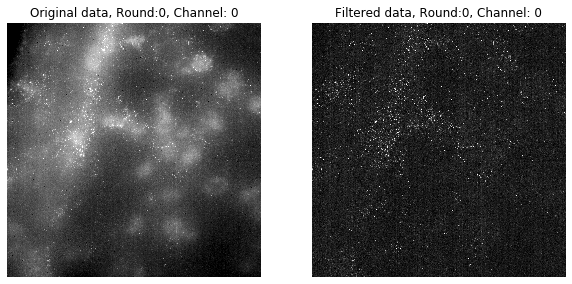

In [43]:
# single_plane = imgs.max_proj(Axes.ZPLANE).xarray.sel({Axes.CH:0}).squeeze()
# single_plane_filtered = mp.xarray.sel({Axes.CH: 0}).squeeze()
# plt.imsave('single_plane_filtered.png', single_plane_filtered, cmap='gray')

# plt.figure(figsize=(10,10))
# plt.subplot(121)
# plt.imshow(single_plane, cmap='gray', clim = list(np.percentile(single_plane.data, [1, 99.9])))
# plt.axis('off')
# plt.title('Original data, Round:0, Channel: 0')
# plt.subplot(122)
# plt.imshow(single_plane_filtered, cmap='gray', clim = list(np.percentile(single_plane_filtered.data, [1, 99.9])))
# plt.title('Filtered data, Round:0, Channel: 0')
# plt.axis('off');

In [138]:
if not os.path.exists('./bootstrap_data/'):
    os.mkdir('./bootstrap_data/')

In [139]:
test_img_path = 'single_plane_filtered.png'
im = imread(test_img_path, as_gray=True)
img_height = len(im)
expert_path = 'filtered.csv'
expert_coords = np.asarray(pd.read_csv(expert_path))
num_spots_total = len(expert_coords)

In [140]:
num_spots_list = [25, 50, 100, 200]
test_thresholds = [0.0050, 0.0075, 0.0100, 0.0150,0.02, 0.03, 0.04, 0.05]
num_iter = 1

In [72]:
from skimage.feature import blob_log

num_spots_sample = %s 25
0.005
0.0075
0.01
0.015
0.02
0.03
0.04
0.05
0.23328618576143328 0.5280373831775701


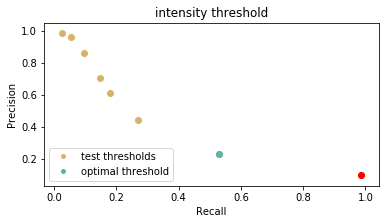

num_blobs = 10605


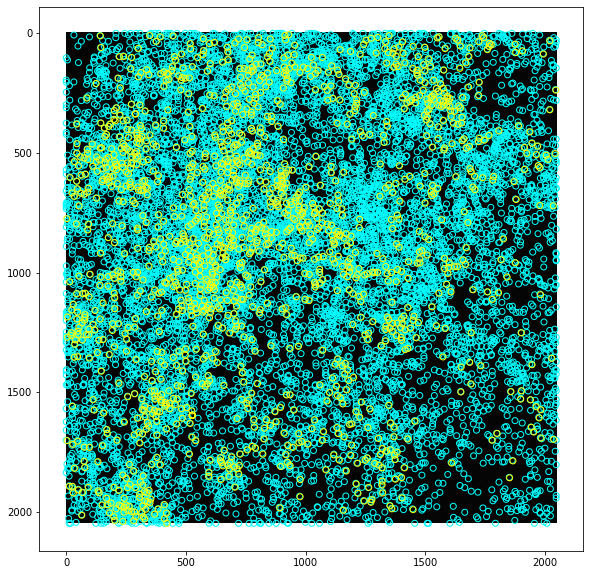

num_spots_sample = %s 50
0.005
0.0075
0.01
0.015
0.02
0.03
0.04
0.05
0.2313969813969814 0.5527369826435247


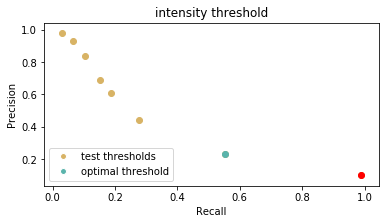

num_blobs = 11396


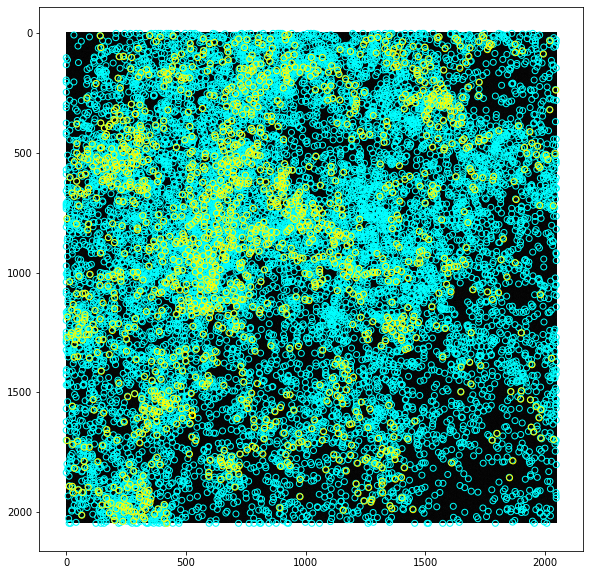

num_spots_sample = %s 100
0.005
0.0075
0.01
0.015
0.02
0.03
0.04
0.05
0.22458296751536436 0.5554072096128171


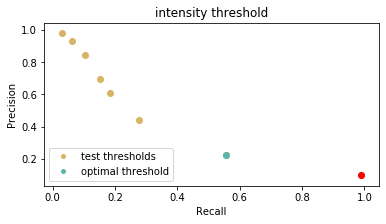

num_blobs = 11390


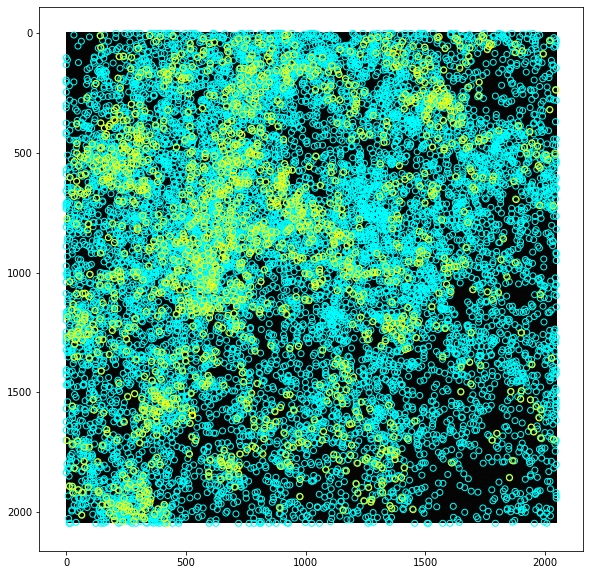

num_spots_sample = %s 200
0.005
0.0075
0.01
0.015
0.02
0.03
0.04
0.05
0.2073295948187347 0.589452603471295


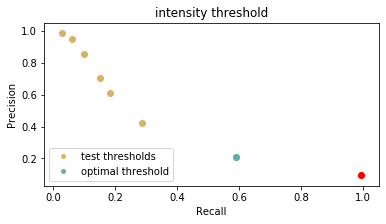

num_blobs = 12661


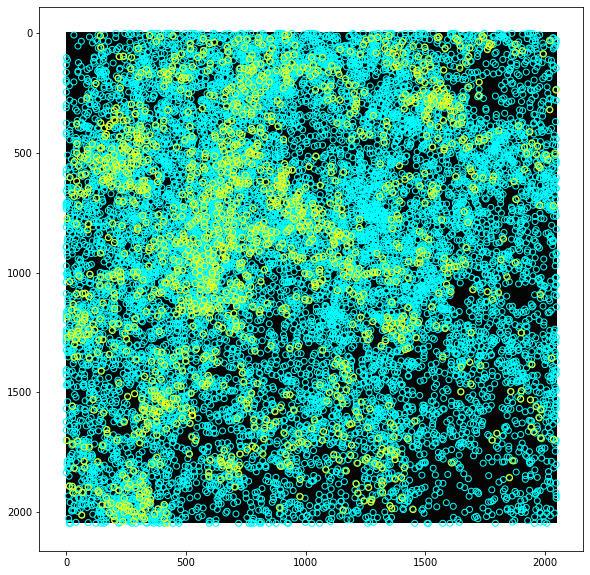

In [141]:
precision_mean_list, precision_std_list, recall_mean_list, recall_std_list = [], [], [], []

for num_spots_sample in num_spots_list:
    
    print('num_spots_sample = %s', num_spots_sample)

    precision_of_blobs_list, recall_of_blobs_list, best_thresholds_list = [], [], []

    for n in range(num_iter):

        # sample fraction of coords
        idx = np.random.randint(num_spots_total, size=num_spots_sample)
        sample_coords = expert_coords[idx,:]

        # extract params from sample
        sigma_list = util.get_sigma_list(test_img_path, sample_coords, margin)
                
        if not sigma_list:
            continue

        # calc precision and recall (based on total expert)
        ref_coords = np.asarray(pd.read_csv(expert_path))

        best_threshold, best_recall, best_precision, recall_list, precision_list = util.get_best_threshold(
            ref_coords, test_img_path, min(sigma_list), max(sigma_list), correctness_threshold, test_thresholds)

        print(best_precision, best_recall)
        precision_of_blobs_list.append(best_precision)
        recall_of_blobs_list.append(best_recall)
        best_thresholds_list.append(best_threshold)
        
        plt.figure(figsize = (6, 3))
        plt.scatter(recall_list, precision_list, c='#d8b365')
        plt.scatter(recall_list[0], precision_list[0], c='red')
        plt.scatter([best_recall], [best_precision], c='#5ab4ac')
        plt.xlabel('Recall')
        plt.ylabel('Precision')

        handle1 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#d8b365', label='test thresholds')
        handle2 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#5ab4ac', label='optimal threshold')
        plt.legend(handles=[handle1, handle2], loc='lower left')

        plt.title('Intensity threshold')
        plt.savefig('spot_intensity_hist.pdf', transparent=True, bbox_inches="tight")
        plt.show()

#         # spot calling using params
#         p = DetectSpots.BlobDetector(
#             min_sigma=min(sigma_list),
#             max_sigma=max(sigma_list),
#             num_sigma=10,
#             threshold=best_threshold,
#             measurement_type='mean',
#         )
#         new_stack = imgs.from_numpy(imgs.xarray.values) 
#         intensities = p.run(new_stack)
#         spots = intensities[:, 0, 0].where(intensities[:, 0, 0] != 0, drop=True)
#         x_vals = spots.x.values
#         if len(x_vals)==0:
#             continue
#         y_vals = spots.y.values
#         blobs = []
#         for x, y in zip(x_vals, y_vals):
#             blobs.append([x, y])
#         blobs = np.asarray(blobs)

        blobs_log = blob_log(
            im, 
            min_sigma=min(sigma_list), 
            max_sigma=max(sigma_list), 
            num_sigma=10, 
            threshold=best_threshold)
        blobs = []
        for r, c, sigma in blobs_log:
            blobs.append([c, r])
        blobs = np.asarray(blobs)
        
        np.savetxt('./bootstrap_data/%s_blobs_%s.csv' % (test_img_filename, str(num_spots_sample)), blobs)
    
        print('num_blobs = %s' % len(blobs))
    
        # calc precision and recall (based on total expert)
#         ref_coords = np.asarray(pd.read_csv(expert_path))

        ####################
        plt.figure(figsize=(10,10))
        plt.scatter(blobs[:,0], blobs[:,1], edgecolor='cyan', facecolor='None')
#         for x, y in blobs:
#             plt.scatter([x], [y], edgecolor='cyan', facecolor='None')
        plt.imshow(im, cmap='gray')
#         for x, y in ref_coords:
#             plt.scatter([x], [y], edgecolor='yellow', facecolor='None')
        ref_coords = np.asarray(pd.read_csv(expert_path))

        plt.scatter(ref_coords[:,0], ref_coords[:,1], edgecolor='yellow', facecolor='None')
        plt.show()
        ####################                

#         precision, recall = util.get_precision_recall(test_coords=blobs, ref_coords=expert_coords, correctness_threshold=correctness_threshold)

    path_a = './bootstrap_data/%s_precisions_%s.csv' % (test_img_filename, str(num_spots_sample))
    path_b = './bootstrap_data/%s_recalls_%s.csv' % (test_img_filename, str(num_spots_sample))
    path_c = './bootstrap_data/%s_thresholds_%s.csv' % (test_img_filename, str(num_spots_sample))
    np.savetxt(path_a, precision_of_blobs_list, delimiter=',')
    np.savetxt(path_b, recall_of_blobs_list, delimiter=',')
    np.savetxt(path_c, best_thresholds_list, delimiter=',')

    precision_mean_list.append(np.mean(precision_of_blobs_list))
    precision_std_list.append(np.std(precision_of_blobs_list))
    recall_mean_list.append(np.mean(recall_of_blobs_list))
    recall_std_list.append(np.std(recall_of_blobs_list))

# save mean and std precision and recall lists
path1 = './bootstrap_data/%s_precision_means.csv' % (test_img_filename)
path2 = './bootstrap_data/%s_precision_stds.csv' % (test_img_filename)
path3 = './bootstrap_data/%s_recall_means.csv' % (test_img_filename)
path4 = './bootstrap_data/%s_recall_stds.csv' % (test_img_filename)
np.savetxt(path1, precision_mean_list, delimiter=",")
np.savetxt(path2, precision_std_list, delimiter=",")
np.savetxt(path3, recall_mean_list, delimiter=",")
np.savetxt(path4, recall_std_list, delimiter=",")

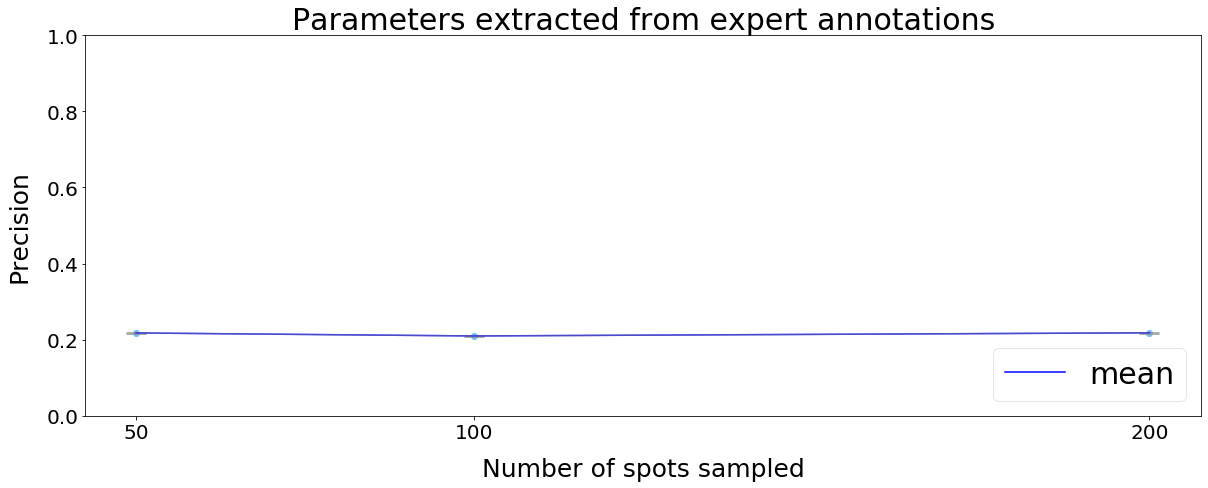

In [106]:
plt.figure(figsize=(20,7))
title = 'Parameters extracted from expert annotations'
plt.title(title, fontsize=30)
precision_means, precision_stds = [], []
for ind, num_spots_sample in enumerate(num_spots_list):

    precisions_path = './bootstrap_data/%s_precisions_%s.csv' % (test_img_filename, num_spots_sample)
    precisions = np.asarray(pd.read_csv(precisions_path, header=None))
    precision_means.append(np.mean(precisions))
    precision_stds.append(np.std(precisions))
    plt.scatter([num_spots_sample]*len(precisions), [precisions], c='xkcd:sky blue')

(_, caps, _) = plt.errorbar(num_spots_list, precision_means, yerr=precision_stds, color='xkcd:gray', capsize=10, elinewidth=3, alpha=0.5)
for cap in caps:
    cap.set_color('xkcd:gray')
    cap.set_markeredgewidth(3)

plt.plot(num_spots_list, precision_means, color='b')
plt.xlabel('Number of spots sampled', fontsize=25, labelpad=15)
plt.ylabel('Precision', fontsize=25, labelpad=15)

leg_elem_1 = Line2D([0], [0], marker='None', color='b', label='mean')
handle_list = [leg_elem_1]
plt.legend(handles=handle_list, loc='lower right', frameon=1, prop={'size':30}, framealpha=0.5)
plt.xticks(num_spots_list, fontsize=20)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)

filename = "%s_bootstrap_precision.pdf" % (test_img_filename)
plt.savefig(filename, transparent=True, bbox_inches="tight")
plt.show()
        

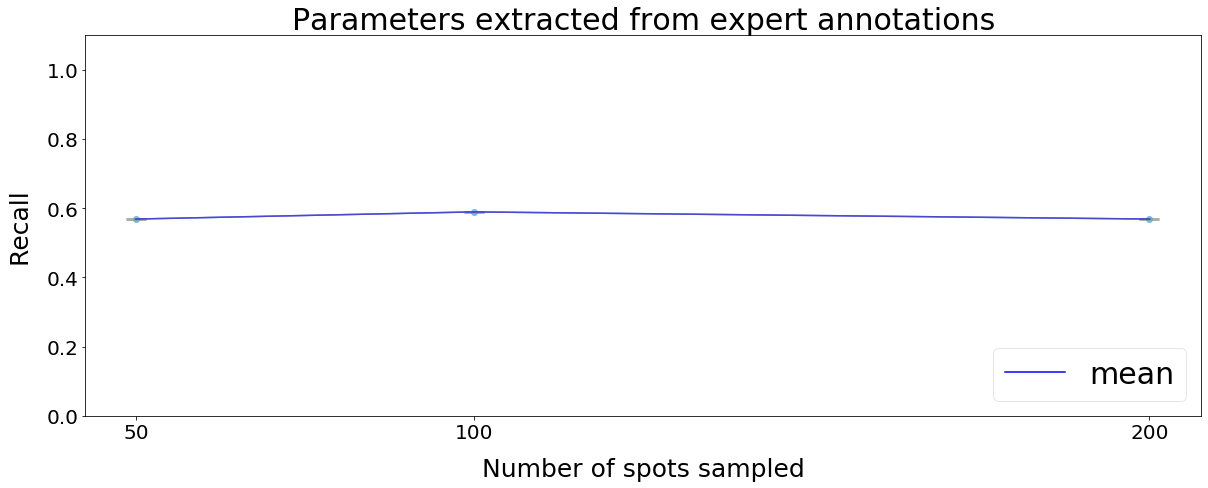

In [107]:
plt.figure(figsize=(20,7))
title = 'Parameters extracted from expert annotations'
plt.title(title, fontsize=30)
recall_means, recall_stds = [], []
for ind, num_spots_sample in enumerate(num_spots_list):

    recalls_path = './bootstrap_data/%s_recalls_%s.csv' % (test_img_filename, num_spots_sample)
    recalls = np.asarray(pd.read_csv(recalls_path, header=None))

    recall_means.append(np.mean(recalls))
    recall_stds.append(np.std(recalls))
    plt.scatter([num_spots_sample]*len(recalls), [recalls], c='xkcd:sky blue')

(_, caps, _) = plt.errorbar(num_spots_list, recall_means, yerr=recall_stds, color='xkcd:gray', capsize=10, elinewidth=3, alpha=0.5)
for cap in caps:
    cap.set_color('xkcd:gray')
    cap.set_markeredgewidth(3)

plt.plot(num_spots_list, recall_means, color='b')
plt.xlabel('Number of spots sampled', fontsize=25, labelpad=15)
plt.ylabel('Recall', fontsize=25, labelpad=15)

leg_elem_1 = Line2D([0], [0], marker='None', color='b', label='mean')
handle_list = [leg_elem_1]
plt.legend(handles=handle_list, loc='lower right', frameon=1, prop={'size':30}, framealpha=0.5)
plt.xticks(num_spots_list, fontsize=20)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
plt.ylim(0, 1.1)

filename = "%s_bootstrap_recall.pdf" % (test_img_filename)
plt.savefig(filename, transparent=True, bbox_inches="tight")
plt.show()
